In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 총발전, 총소비 데이터 추출

In [2]:
df1 = pd.read_csv('./211104/211104 dashboard_time_series_chart.csv', parse_dates = True)

In [3]:
df1['DateTime']= pd.to_datetime(df1['DateTime'])

In [4]:
df1=df1[(df1['DateTime']>='2021-09-13 00:00:00')]

In [5]:
df1=df1[(df1['DateTime']<'2021-11-04 00:00:00')]

In [6]:
df1=df1.set_index('DateTime')

In [7]:
df1=df1.resample('1T').mean()

In [8]:
df1=df1.fillna(0)

In [9]:
df1

,energyTotalProduce,energyTotalConsume,ToESS(We),ESSout(We),energyTotalSelfConsumeRate,energyTotalSelfRate,SCF,LCF,SCF_acc,LCF_acc
DateTime,,,,,,,,,,
2021-09-13 00:00:00,9.869,6694.41,118.000,0.0,1.0,0.240607,0.0,0.000000,0.0,0.000000
2021-09-13 00:01:00,0.000,0.00,0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
2021-09-13 00:02:00,0.000,0.00,0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
2021-09-13 00:03:00,9.334,6440.19,112.667,0.0,1.0,0.240602,0.0,0.000000,0.0,0.000000
2021-09-13 00:04:00,0.000,0.00,0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,569.283,7573.30,0.000,0.0,1.0,0.714178,1.0,0.075170,1.0,0.366645
2021-11-03 23:56:00,567.933,7719.92,0.000,0.0,1.0,0.714173,1.0,0.073567,1.0,0.366642
2021-11-03 23:57:00,567.933,7962.67,0.000,0.0,1.0,0.714168,1.0,0.071324,1.0,0.366640


# ESS충방전량 추출

In [10]:
df2 = pd.read_csv('./211104/211104 kepsh1.csv', parse_dates = True)

In [11]:
df2['DateTime']= pd.to_datetime(df2['DateTime'])

In [12]:
df2=df2[(df2['DateTime']>='2021-09-13 00:00:00')]

In [13]:
df2=df2[(df2['DateTime']<'2021-11-04 00:00:00')]

In [14]:
df2=df2.set_index('DateTime')

In [15]:
df2=df2.resample('1T').mean()

In [16]:
df2=df2.fillna(0)

In [17]:
df2

,Room_Temp(�C),T1(�C),T2(�C),T3(�C),T4(�C),T5(�C),T6(�C),T8(�C),T9(�C),T10(�C),...,Pvt_Supply(W),Pv_Supply(W),Heatpump_Load(W),FuelCell_Supply(W),WS_Temperature(�C),WS_SolarRadiation(w/m�),WS_WindDirection_Slope(w/m�),Thermal_Operation_Mode,Total_Consumption(W),Total_Production(W)
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,26.5,38.975,36.197,25.940,23.875,27.271,100.000,25.158,45.849,44.080,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,677.0,9.0
2021-09-13 00:01:00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-13 00:02:00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-13 00:03:00,26.5,38.988,36.235,26.104,24.017,27.390,100.000,25.140,45.847,44.055,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,674.0,9.0
2021-09-13 00:04:00,26.5,38.972,36.238,26.165,24.061,27.433,100.000,25.146,45.857,44.066,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,780.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,26.1,33.109,33.380,31.618,30.754,31.927,30.845,19.279,53.002,37.218,...,-9.0,-50.0,29.0,569.0,17.0,13.4,0.0,0.0,892.0,569.0
2021-11-03 23:56:00,26.1,33.110,33.381,31.586,30.731,31.907,30.812,19.283,53.003,37.222,...,-9.0,-50.0,29.0,568.0,17.0,13.4,0.0,0.0,896.0,568.0
2021-11-03 23:57:00,26.1,33.108,33.378,31.565,30.708,31.888,30.785,19.282,52.997,37.227,...,-9.0,-50.0,29.0,568.0,17.0,13.4,0.0,0.0,897.0,568.0


# ToGrid 데이터 추출

In [18]:
df3 = pd.read_csv('./211104/211104 dashboard_facility_enegy_flow.csv', parse_dates = True)

In [19]:
df3['DateTime']= pd.to_datetime(df3['DateTime'])

In [20]:
df3=df3[(df3['DateTime']>='2021-09-13 00:00:00')]

In [21]:
df3=df3[(df3['DateTime']<'2021-11-04 00:00:00')]

In [22]:
df3=df3.set_index('DateTime')

In [23]:
df3=df3.resample('1T').mean()

In [24]:
df3=df3.fillna(0)

In [25]:
df3

,PVout(We),PVTout(We),FCout(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),ToESS(We),ESSout(We),ESS2Grid(We),...,GSHP2HTES(Wt),ASHP2Cool(Wt),ASHP2Heat(Wt),CTES2Cool(Wt),HTES2Heat(Wt),HTES2Water(Wt),DirectElec(We),CoolLoad(Wt),HeatLoad(Wt),HotwaterLoad(Wt)
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:04:00,-80.638,9.414,0.000,2626.05,649.629,6360.67,0.0,112.672,0.0,0.0,...,0.0,2393.78,0.0,0.0,0.0,0.0,3275.68,2393.78,0.0,0.0
2021-09-13 00:05:00,0.000,0.000,0.000,0.00,0.000,0.00,0.0,0.000,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2021-09-13 00:06:00,-78.139,9.667,0.000,2492.71,640.722,5702.08,0.0,112.333,0.0,0.0,...,0.0,2436.01,0.0,0.0,0.0,0.0,3133.43,2436.01,0.0,0.0
2021-09-13 00:07:00,0.000,0.000,0.000,0.00,0.000,0.00,0.0,0.000,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2021-09-13 00:08:00,-79.959,9.552,0.000,2394.03,641.167,6580.36,0.0,112.310,0.0,0.0,...,0.0,2497.65,0.0,0.0,0.0,0.0,3035.20,2497.65,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,-82.800,-74.267,569.233,6000.10,1339.370,7004.02,0.0,0.000,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,7339.47,0.00,0.0,0.0
2021-11-03 23:56:00,-82.867,-74.600,567.933,6016.00,1470.630,7151.98,0.0,0.000,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,7486.64,0.00,0.0,0.0
2021-11-03 23:57:00,-82.717,-74.600,567.933,5963.23,1765.020,7394.73,0.0,0.000,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,7728.25,0.00,0.0,0.0


# KPEC 합치기

In [47]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:04:00', '2021-11-03 23:59:00', freq='T'), columns=['Time'])

In [48]:
df_kpec = df_kpec.set_index('Time')

In [49]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS_Power(W)']*(-1)

In [50]:
df_kpec['PV_kpec(We)'] = df3['PVout(We)']
df_kpec['PVT_kpec(We)'] = df3['PVTout(We)']
df_kpec['FC_kpec(We)'] = df3['FCout(We)']
df_kpec['PlugLoad(We)'] = df3['PlugLoad(We)']
df_kpec['LightLoad(We)'] = df3['LightLoad(We)']
df_kpec['FromGrid(We)'] = df3['FromGrid(We)']
df_kpec['ToGrid(We)'] = df3['ToGrid(We)']
df_kpec['ToESS(We)'] = df3['ToESS(We)']
df_kpec['ESSout(We)'] = df3['ESSout(We)']
df_kpec['ESS2Grid(We)'] = df3['ESS2Grid(We)']
df_kpec['ESS2ASHP(We)'] = df3['ESS2ASHP(We)']
df_kpec['ESS2GSHP(We)'] = df3['ESS2GSHP(We)']
df_kpec['Grid2ASHP(We)'] = df3['Grid2ASHP(We)']
df_kpec['Grid2GSHP(We)'] = df3['Grid2GSHP(We)']
df_kpec['PVTHout(Wt)'] = df3['PVTHout(Wt)']
df_kpec['FCHout(Wt)'] = df3['FCHout(Wt)']
df_kpec['ASHP2HTES(Wt)'] = df3['ASHP2HTES(Wt)']
df_kpec['GSHP2CTES(Wt)'] = df3['GSHP2CTES(Wt)']
df_kpec['GSHP2HTES(Wt)'] = df3['GSHP2HTES(Wt)']
df_kpec['ASHP2Cool(Wt)'] = df3['ASHP2Cool(Wt)']
df_kpec['ASHP2Heat(Wt)'] = df3['ASHP2Heat(Wt)']
df_kpec['CTES2Cool(Wt)'] = df3['CTES2Cool(Wt)']
df_kpec['HTES2Heat(Wt)'] = df3['HTES2Heat(Wt)']
df_kpec['HTES2Water(Wt)'] = df3['HTES2Water(Wt)']
df_kpec['DirectElec(We)'] = df3['DirectElec(We)']
df_kpec['CoolLoad(Wt)'] = df3['CoolLoad(Wt)']
df_kpec['HeatLoad(Wt)'] = df3['HeatLoad(Wt)']
df_kpec['HotwaterLoad(Wt)'] = df3['HotwaterLoad(Wt)']


In [51]:
df_kpec['PV_kpec(We)'] = np.where(df_kpec['PV_kpec(We)']<0, 0, df_kpec['PV_kpec(We)'])
df_kpec['PVT_kpec(We)'] = np.where(df_kpec['PVT_kpec(We)']<0, 0, df_kpec['PVT_kpec(We)'])
df_kpec['FC_kpec(We)'] = np.where(df_kpec['FC_kpec(We)']<0, 0, df_kpec['FC_kpec(We)'])
df_kpec['PlugLoad(We)'] = np.where(df_kpec['PlugLoad(We)']<0, 0, df_kpec['PlugLoad(We)'])

In [52]:
df_kpec = df_kpec[df_kpec['Cons_kpec(W)']< 40000]

In [53]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),...,GSHP2HTES(Wt),ASHP2Cool(Wt),ASHP2Heat(Wt),CTES2Cool(Wt),HTES2Heat(Wt),HTES2Water(Wt),DirectElec(We),CoolLoad(Wt),HeatLoad(Wt),HotwaterLoad(Wt)
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:04:00,0.00,0.000,-0.0,0.0,9.414,0.000,2626.05,649.629,6360.67,0.0,...,0.0,2393.78,0.0,0.0,0.0,0.0,3275.68,2393.78,0.0,0.0
2021-09-13 00:05:00,0.00,0.000,-0.0,0.0,0.000,0.000,0.00,0.000,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2021-09-13 00:06:00,5711.75,9.667,-0.0,0.0,9.667,0.000,2492.71,640.722,5702.08,0.0,...,0.0,2436.01,0.0,0.0,0.0,0.0,3133.43,2436.01,0.0,0.0
2021-09-13 00:07:00,5851.42,9.464,-0.0,0.0,0.000,0.000,0.00,0.000,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2021-09-13 00:08:00,6590.12,9.766,-0.0,0.0,9.552,0.000,2394.03,641.167,6580.36,0.0,...,0.0,2497.65,0.0,0.0,0.0,0.0,3035.20,2497.65,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,7573.30,569.283,-0.0,0.0,0.000,569.233,6000.10,1339.370,7004.02,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,7339.47,0.00,0.0,0.0
2021-11-03 23:56:00,7719.92,567.933,-0.0,0.0,0.000,567.933,6016.00,1470.630,7151.98,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,7486.64,0.00,0.0,0.0
2021-11-03 23:57:00,7962.67,567.933,-0.0,0.0,0.000,567.933,5963.23,1765.020,7394.73,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,7728.25,0.00,0.0,0.0


In [54]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600

df_kpec['PV_acc_kpec(Wh)'] = df_kpec['PV_kpec(We)'].cumsum()*60*1/3600
df_kpec['PVT_acc_kpec(Wh)'] = df_kpec['PVT_kpec(We)'].cumsum()*60*1/3600
df_kpec['FC_acc_kpec(Wh)'] = df_kpec['FC_kpec(We)'].cumsum()*60*1/3600
df_kpec['PlugLoad_acc(Wh)'] = df_kpec['PlugLoad(We)'].cumsum()*60*1/3600
df_kpec['LightLoad_acc(Wh)'] = df_kpec['LightLoad(We)'].cumsum()*60*1/3600
df_kpec['FromGrid_acc(Wh)'] = df_kpec['FromGrid(We)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(We)'].cumsum()*60*1/3600
df_kpec['ToESS_acc(Wh)'] = df_kpec['ToESS(We)'].cumsum()*60*1/3600
df_kpec['ESSout_acc(Wh)'] = df_kpec['ESSout(We)'].cumsum()*60*1/3600
df_kpec['ESS2Grid_acc(Wh)'] = df_kpec['ESS2Grid(We)'].cumsum()*60*1/3600
df_kpec['ESS2ASHP_acc(Wh)'] = df_kpec['ESS2ASHP(We)'].cumsum()*60*1/3600
df_kpec['ESS2GSHP_acc(Wh)'] = df_kpec['ESS2GSHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2ASHP_acc(Wh)'] = df_kpec['Grid2ASHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2GSHP_acc(Wh)'] = df_kpec['Grid2GSHP(We)'].cumsum()*60*1/3600
df_kpec['PVTHout_acc(Wh)'] = df_kpec['PVTHout(Wt)'].cumsum()*60*1/3600
df_kpec['FCHout_acc(Wh)'] = df_kpec['FCHout(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2HTES_acc(Wh)'] = df_kpec['ASHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2CTES_acc(Wh)'] = df_kpec['GSHP2CTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2HTES_acc(Wh)'] = df_kpec['GSHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Cool_acc(Wh)'] = df_kpec['ASHP2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Heat_acc(Wh)'] = df_kpec['ASHP2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['CTES2Cool_acc(Wh)'] = df_kpec['CTES2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Heat_acc(Wh)'] = df_kpec['HTES2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Water_acc(Wh)'] = df_kpec['HTES2Water(Wt)'].cumsum()*60*1/3600
df_kpec['DirectElec_acc(Wh)'] = df_kpec['DirectElec(We)'].cumsum()*60*1/3600
df_kpec['CoolLoad_acc(Wh)'] = df_kpec['CoolLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HeatLoad_acc(Wh)'] = df_kpec['HeatLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HotwaterLoad_acc(Wh)'] = df_kpec['HotwaterLoad(Wt)'].cumsum()*60*1/3600

In [55]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(We)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

In [56]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [57]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [58]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [59]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [60]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74872 entries, 2021-09-13 00:04:00 to 2021-11-03 23:59:00
Data columns (total 72 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cons_kpec(W)          74872 non-null  float64
 1   Prod_kpec(W)          74872 non-null  float64
 2   ESS_kpec(W)           74872 non-null  float64
 3   PV_kpec(We)           74872 non-null  float64
 4   PVT_kpec(We)          74872 non-null  float64
 5   FC_kpec(We)           74872 non-null  float64
 6   PlugLoad(We)          74872 non-null  float64
 7   LightLoad(We)         74872 non-null  float64
 8   FromGrid(We)          74872 non-null  float64
 9   ToGrid(We)            74872 non-null  float64
 10  ToESS(We)             74872 non-null  float64
 11  ESSout(We)            74872 non-null  float64
 12  ESS2Grid(We)          74872 non-null  float64
 13  ESS2ASHP(We)          74872 non-null  float64
 14  ESS2GSHP(We)          74872 non-nul

In [61]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),...,E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:04:00,0.00,0.000,-0.0,0.0,9.414,0.000,2626.05,649.629,6360.67,0.0,...,0.000,0.000000e+00,0.000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:05:00,0.00,0.000,-0.0,0.0,0.000,0.000,0.00,0.000,0.00,0.0,...,0.000,0.000000e+00,0.000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:06:00,5711.75,9.667,-0.0,0.0,9.667,0.000,2492.71,640.722,5702.08,0.0,...,9.667,1.611167e-01,9.667,1.611167e-01,1.0,0.001692,1.000000,0.001692,0.001692,0.500846
2021-09-13 00:07:00,5851.42,9.464,-0.0,0.0,0.000,0.000,0.00,0.000,0.00,0.0,...,9.464,3.188500e-01,9.464,3.188500e-01,1.0,0.001617,1.000000,0.001654,0.001654,0.500827
2021-09-13 00:08:00,6590.12,9.766,-0.0,0.0,9.552,0.000,2394.03,641.167,6580.36,0.0,...,9.766,4.816167e-01,9.766,4.816167e-01,1.0,0.001482,1.000000,0.001592,0.001592,0.500796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,7573.30,569.283,-0.0,0.0,0.000,569.233,6000.10,1339.370,7004.02,0.0,...,569.283,4.622471e+06,569.283,4.622471e+06,1.0,0.075170,0.459038,0.466913,1.018497,0.462975
2021-11-03 23:56:00,7719.92,567.933,-0.0,0.0,0.000,567.933,6016.00,1470.630,7151.98,0.0,...,567.933,4.622480e+06,567.933,4.622480e+06,1.0,0.073567,0.459038,0.466908,1.018485,0.462973
2021-11-03 23:57:00,7962.67,567.933,-0.0,0.0,0.000,567.933,5963.23,1765.020,7394.73,0.0,...,567.933,4.622490e+06,567.933,4.622490e+06,1.0,0.071324,0.459039,0.466903,1.018472,0.462971


In [62]:
df_kpec.to_csv('./211109_kpec_tot.csv')

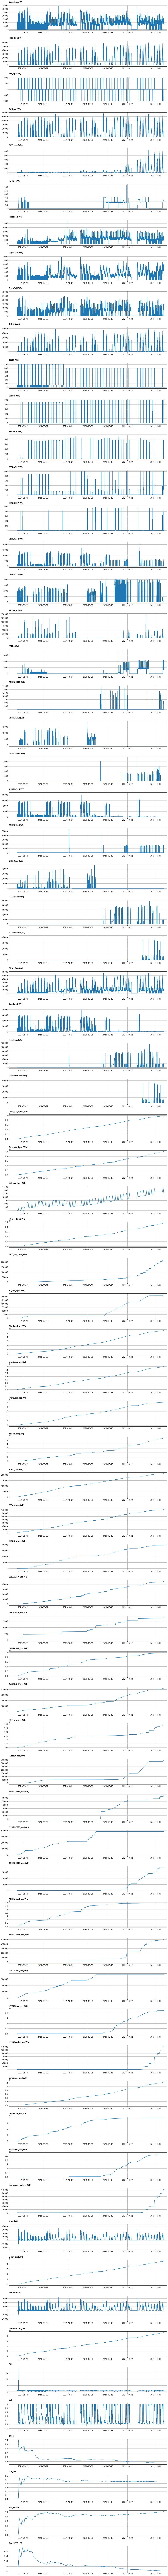

In [63]:
fig, ax = plt.subplots(figsize=(18,300))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    plt.plot(df_kpec[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [64]:
df = pd.read_csv('./211109_kpec_tot.csv', parse_dates = True)

In [65]:
df

,Time,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),...,E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
0,2021-09-13 00:04:00,0.00,0.000,-0.0,0.0,9.414,0.000,2626.05,649.629,6360.67,...,0.000,0.000000e+00,0.000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-13 00:05:00,0.00,0.000,-0.0,0.0,0.000,0.000,0.00,0.000,0.00,...,0.000,0.000000e+00,0.000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-13 00:06:00,5711.75,9.667,-0.0,0.0,9.667,0.000,2492.71,640.722,5702.08,...,9.667,1.611167e-01,9.667,1.611167e-01,1.0,0.001692,1.000000,0.001692,0.001692,0.500846
3,2021-09-13 00:07:00,5851.42,9.464,-0.0,0.0,0.000,0.000,0.00,0.000,0.00,...,9.464,3.188500e-01,9.464,3.188500e-01,1.0,0.001617,1.000000,0.001654,0.001654,0.500827
4,2021-09-13 00:08:00,6590.12,9.766,-0.0,0.0,9.552,0.000,2394.03,641.167,6580.36,...,9.766,4.816167e-01,9.766,4.816167e-01,1.0,0.001482,1.000000,0.001592,0.001592,0.500796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74867,2021-11-03 23:55:00,7573.30,569.283,-0.0,0.0,0.000,569.233,6000.10,1339.370,7004.02,...,569.283,4.622471e+06,569.283,4.622471e+06,1.0,0.075170,0.459038,0.466913,1.018497,0.462975
74868,2021-11-03 23:56:00,7719.92,567.933,-0.0,0.0,0.000,567.933,6016.00,1470.630,7151.98,...,567.933,4.622480e+06,567.933,4.622480e+06,1.0,0.073567,0.459038,0.466908,1.018485,0.462973
74869,2021-11-03 23:57:00,7962.67,567.933,-0.0,0.0,0.000,567.933,5963.23,1765.020,7394.73,...,567.933,4.622490e+06,567.933,4.622490e+06,1.0,0.071324,0.459039,0.466903,1.018472,0.462971
74870,2021-11-03 23:58:00,8019.32,569.500,-0.0,0.0,0.000,569.500,6032.48,1751.720,7449.82,...,569.500,4.622499e+06,569.500,4.622499e+06,1.0,0.071016,0.459039,0.466898,1.018460,0.462968


In [66]:
df['Time']= pd.to_datetime(df['Time'])

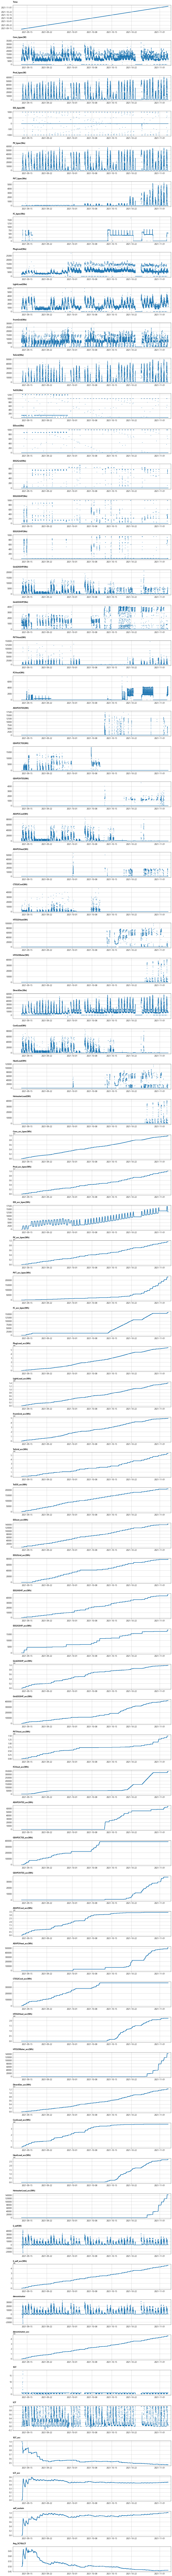

In [67]:
fig, ax = plt.subplots(figsize=(18,300))


for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    name = df.columns[i]
    plt.scatter(x=df['Time'], y=df[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()